In [1]:
library(Seurat)
library(ggplot2)
library(R.matlab)
library(anndata)
library(MySeuratWrappers)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.


Attaching package: ‘R.matlab’


The following objects are masked from ‘package:base’:

    getOption, isOpen


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: reticulate

Loading required package: tidyr


Attaching 

In [9]:
library(future)
availableCores()

system 
   144

In [13]:
#使用plan来查看当前plan的情况
plan()
#此处我们想调用4个核来并行完成我们的marker基因鉴定
plan("multicore", workers = 40)
options(future.globals.maxSize= 89128960000)

multicore:
- args: function (..., workers = 40, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 40)

In [4]:
mytheme <- theme(panel.border = element_rect(size = 1.5, colour = "grey25"),
                 axis.line = element_blank(),
                 axis.ticks = element_blank(),
                 axis.title = element_blank(),
                 axis.text = element_blank(),
                 legend.position = "none",
                 plot.title = element_blank(),
                 legend.text = element_text(size = 14))

In [29]:
integrated <- readRDS("/home/suyanchi/project/dab/results/case/rds/CD45pPBMC.integrated.rds")
integrated

An object of class Seurat 
19845 features across 36030 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

In [7]:
dat <- read_h5ad("/home/suyanchi/project/dab/results/PBMC.h5ad")
dat

AnnData object with n_obs × n_vars = 36030 × 17845

In [26]:
cell_name = colnames(integrated)
gene_name = rownames(integrated)
X = dat$X
rownames(X) = cell_name
colnames(X) = gene_name

,AL669831.5,LINC00115,FAM41C,AL645608.3,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,⋯,AC006547.2,RSPH14,DRICH1,GSTT2B,AL022329.2,PVALB,Z83844.1,RIBC2,AL022328.1,AP000569.1
AAACCTGAGGAATTAC-1_1,0,0,0,0,0.02674362,0,0,0,0.1397109,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACCTGCATCCGGGT-1_1,0,0,0,0,0.12506016,0,0,0,1.0000000,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACGGGAGATACACA-1_1,1,0,0,0,0.05583361,1,0,0,0.2943141,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACGGGAGGCTAGAC-1_1,0,0,0,0,0.07043837,0,0,0,0.1985209,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACGGGCAGTCCTTC-1_1,0,0,0,0,0.02218262,0,0,0,0.1991209,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACGGGGTGAAGGCT-1_1,0,0,0,0,0.08093769,0,0,0,1.0000000,0,⋯,0,0,0,0,0,0,0,0,0,0


In [30]:
integrated[['RNA']]@data = t(X)
integrated

An object of class Seurat 
19845 features across 36030 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

In [32]:
DefaultAssay(integrated) <- "RNA"
# integrated <- NormalizeData(integrated, normalization.method = "LogNormalize", scale.factor = 10000)
integrated <- FindVariableFeatures(integrated, selection.method = "vst", nfeatures = 2000)
integrated <- ScaleData(integrated)
# DefaultAssay(integrated) <- "integrated"
integrated <- RunPCA(integrated, features = VariableFeatures(integrated))
# Run PCA and Determine Dimensions for 90% Variance
PCDeterminators <- function(object){
  stdev <- object@reductions$pca@stdev
  var <- stdev^2
  endVar <- 0
  for(i in 1:length(var)){
    total <- sum(var)
    numerator <- sum(var[1:i])
    exp.var <- numerator/total
    if(endVar == 0){
      if(exp.var > 0.9){
        endVar <- endVar + 1
        PC.num <- i
      }
    }
  }
  sum(var[1:PC.num])/sum(var)
  return(PC.num)
}
PC.num <- PCDeterminators(integrated)
integrated <- FindNeighbors(integrated, dims = 1:PC.num, reduction = "pca")
integrated <- FindClusters(integrated, resolution = seq(0.2, 1.4, 0.2), reduction = "pca")
integrated <- RunUMAP(integrated, dims = 1:PC.num, reduction = "pca")
integrated <- RunTSNE(integrated, dims = 1:PC.num)
saveRDS(integrated,file = "/home/suyanchi/project/dab/results/case/rds/PBMC.dr.rds")

Centering and scaling data matrix

PC_ 1 
Positive:  CD69, CD7, GZMM, TXK, CD3D, CD247, CCL5, IL7R, CD2, CD3G 
	   CST7, TRBC2, CTSW, SPOCK2, IL32, CD6, TRAC, KLRG1, NKG7, TRBC1 
	   LINC01871, KLRD1, GZMA, HOPX, SAMD3, GNLY, TCF7, KLRB1, ITM2A, IFITM1 
Negative:  OAZ1, TYROBP, FTH1, FTL, S100A6, COTL1, PSAP, S100A11, CTSS, SPI1 
	   AIF1, TYMP, PYCARD, FCER1G, LST1, NPC2, SAT1, BRI3, S100A4, TKT 
	   FCN1, FCGRT, CFP, CD68, SERPINA1, CST3, ACTB, GSTP1, GRN, TSPO 
PC_ 2 
Positive:  RPSA, RPLP0, RPS2, RPS18, C12orf75, ACTG1, PFN1, ITGB7, ISG20, LDHB 
	   RAN, IDH2, TAP1, PARP1, PEBP1, APOBEC3G, C1QBP, ATP5MC3, RPS12, PRDX2 
	   CCDC167, TMSB10, HMGB1, IL32, PHB, YBX1, PPA1, P4HB, DDOST, COX5A 
Negative:  VCAN, MNDA, S100A8, S100A9, NAMPT, CD93, CYBB, S100A12, CSF3R, CYP1B1 
	   CD14, CLEC7A, CD36, FOS, RBP7, DUSP6, GCA, CDA, FGL2, LRRK2 
	   LYZ, FPR1, CREB5, TLR2, FAM198B, CLEC4E, EGR1, KCTD12, SLC11A1, CRISPLD2 
PC_ 3 
Positive:  FCGR3A, IFITM2, RHOC, HES4, NKG7, IFITM3, CDKN1C, CHST2

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9507
Number of communities: 12
Elapsed time: 9 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-1’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9277
Number of communities: 17
Elapsed time: 11 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-2’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9088
Number of communities: 20
Elapsed time: 8 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-3’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8945
Number of communities: 24
Elapsed time: 8 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-4’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8825
Number of communities: 26
Elapsed time: 9 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-5’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8714
Number of communities: 30
Elapsed time: 8 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-6’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36030
Number of edges: 1252199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8623
Number of communities: 30
Elapsed time: 8 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-7’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:21:05 UMAP embedding parameters a = 0.9922 b = 1.112

17:21:05 Read 36030 rows and found 21 numeric columns

17:21:05 Using Annoy for neighbor search, n_neighbors = 30

17:21:05 Building Annoy index with metric = cosine

In [55]:
saveRDS(integrated,file = "/home/suyanchi/project/dab/results/case/rds/PBMC.dr.rds")

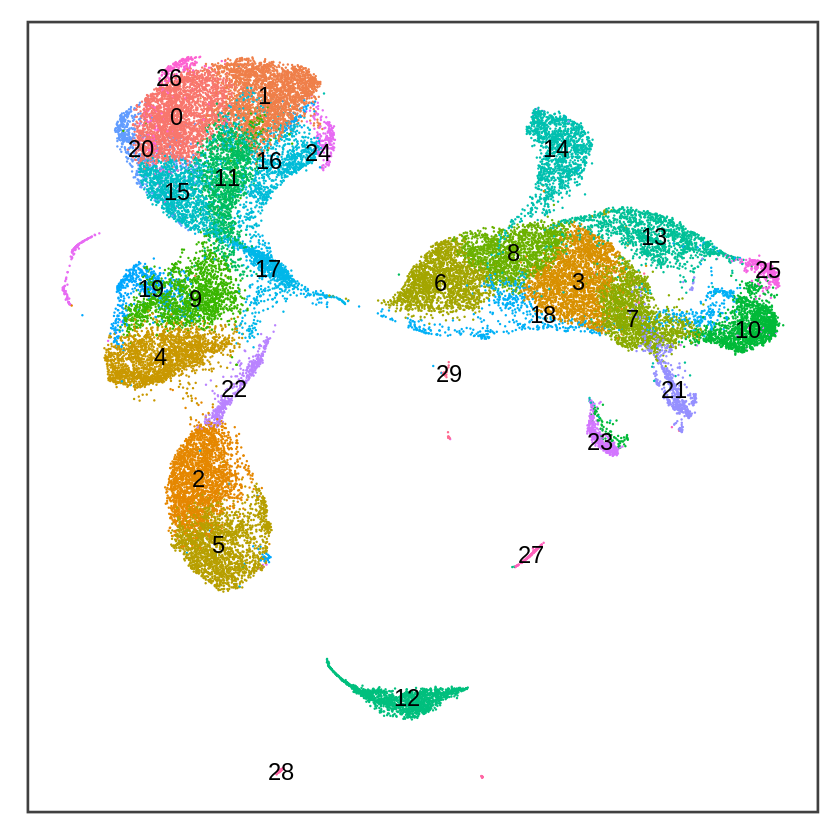

In [40]:
p.ct <- DimPlot(integrated, reduction = "umap", label = T,label.size = 5) + mytheme
p.ct

In [41]:
ggsave("/home/suyanchi/project/dab/results/case/figures/CD45pPBMC.cluster.umap.pdf",p.ct, width = 5,height = 5)

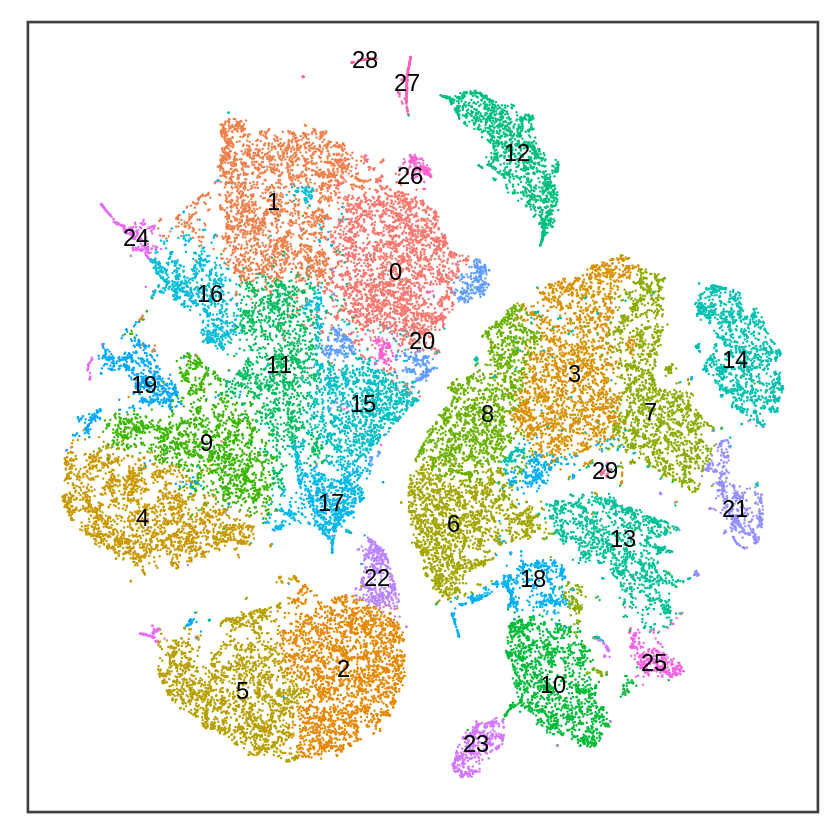

In [38]:
p.ct <- DimPlot(integrated, reduction = "tsne", label = T,label.size = 5) + mytheme
p.ct

In [39]:
ggsave("/home/suyanchi/project/dab/results/case/figures/CD45pPBMC.cluster.tnse.pdf",p.ct, width = 5,height = 5)

In [37]:
DefaultAssay(integrated) <- "RNA"
p.nk <- VlnPlot(integrated,features = c("KLRF1","NKG7","GNLY","KLRD1","NCAM1","GZMA"),stacked = T, pt.size = 0,
                direction = "horizontal",combine = T, x.lab = '', y.lab = '') +
  theme(axis.text.x = element_blank(),axis.ticks.x = element_blank())
ggsave("/home/suyanchi/project/dab/results/case/figures/violin.nk.markers.pdf",p.nk,width = 6,height = 10)

In [ ]:
# read nk names
nk.names = readRDS('/home/suyanchi/project/scHNSCC-main/HNSCC/rds/CD45pPBMC.NK_names.rds')
nk.names

In [45]:
nk_2_5_22 = rownames(subset(integrated@meta.data, seurat_clusters == 2 | seurat_clusters == 5 | seurat_clusters == 22))
length(nk_2_5_22)

[1] 4796

In [47]:
nk_4_9_19 = rownames(subset(integrated@meta.data, seurat_clusters == 4 | seurat_clusters == 9 | seurat_clusters == 19))
length(nk_4_9_19)

[1] 4446

In [49]:
length(intersect(nk.names, nk_2_5_22))

[1] 4320

In [56]:
save(nk_2_5_22, nk_4_9_19, file='/home/suyanchi/project/dab/results/case/rds/nk_cell.RData')

In [50]:
length(intersect(nk.names, nk_4_9_19))

[1] 165

In [60]:
cell.highlight = intersect(nk.names, nk_2_5_22)

Warning message:
“Ignoring unknown parameters: label.colour”


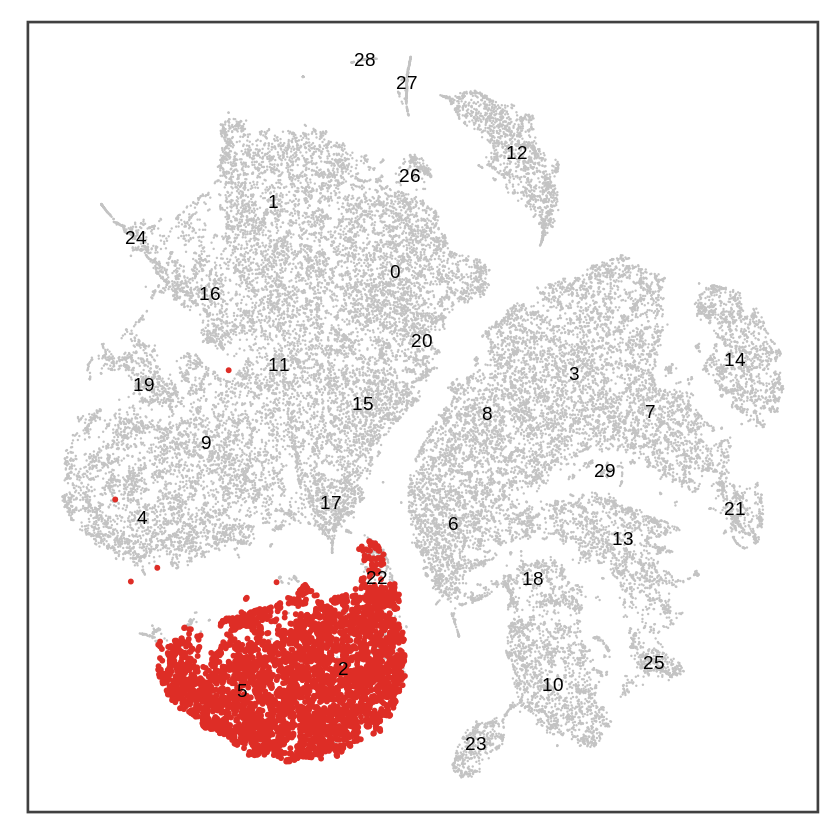

In [61]:
p.NK <- DimPlot(integrated,reduction = "tsne", label = T, cells.highlight = cell.highlight,label.size = 4, 
                label.color = rainbow(length(unique(as.character(integrated$seurat_clusters))))) + mytheme
p.NK

In [62]:
CD45pPBMC.NK <- subset(integrated, cells = intersect(nk.names, nk_2_5_22))
saveRDS(CD45pPBMC.NK, file = "/home/suyanchi/project/dab/results/case/rds/PBMC.NK.rds")